In [1]:
import cv2, dlib, imutils
import numpy as np
from imutils import face_utils
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

/anaconda/envs/py38_default/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def detect_blink(eye_img):
    pred_B = model_b.predict(eye_img, verbose = 0)
    status = pred_B[0][0]
    status = status*100
    status = round(status,3)
    return  status

   
def crop_eye(img, eye_points):
    x1, y1 = np.amin(eye_points, axis=0)
    x2, y2 = np.amax(eye_points, axis=0)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    w = (x2 - x1) * 1.2
    h = w * IMG_SIZE[1] / IMG_SIZE[0]

    margin_x, margin_y = w / 2, h / 2

    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)

    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(int)

    eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

    return eye_img, eye_rect

# load a test image, resize it, and convert it to grayscale
def load_image(path, face_detector, show=False, gray_show=False):
    test_image = cv2.imread(path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
    test_image = imutils.resize(test_image, width=500)
    gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
    
    if show:
        plt.imshow(test_image)
        plt.show()
        if gray_show:
            plt.imshow(gray, cmap='gray')
            plt.show()
    
     # detect faces in the grayscale image
    if face_detector == 'dlib':
        rects = detector(gray, 1)
    elif face_detector == 'haar':
        detections = haar_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5, minSize=(100, 100), flags=cv2.CASCADE_SCALE_IMAGE)
        #Checking if there are more than 1 detected faces
        if len(detections) > 1:
            print('multiple faces', frame)
            # The predicted faces are boxes (same width and height). The last two values correspond to these.
            # So by just checking which is higher, I can find the correct face
            if detections[0][2] > detections[1][2]:
                face = detections[0]
            else:
                face = detections[1]
        else:
            face = detections[0]
        fX, fY, fW, fH = face[0],face[1], face[2], face[3]    
        rects = [dlib.rectangle(fX, fY, fX + fW, fY + fH)]
    return test_image, gray, rects

def get_landmarks(img, gray, rects, show=False):
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then convert the facial landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        if show: 
            # convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x, y, w, h)], then draw the face bounding box
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # loop over the (x, y)-coordinates for the facial landmarks and draw them on the image
            for (x, y) in shape:
                cv2.circle(img, (x, y), 1, (0, 0, 255), -1)
    if show:     
        # show the output image with the face detections + facial landmarks
        plt.imshow(img)
        plt.show()
    return shape

In [4]:
IMG_SIZE = (1296,730)
B_SIZE = (34, 26)

#path = '../test_frames/frame848.jpg'

# haar Cascade path
cascade_path = '../models/haarcascade_frontalface_default.xml'
# create haar cascade
haar_cascade = cv2.CascadeClassifier(cascade_path)

# define pre-trained landmark detector path
ld_path = '../models/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(ld_path)

model_b = load_model('../models/blinkdetection.h5')

face_detector = 'haar'

2022-10-05 08:41:16.562979: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-05 08:41:16.563043: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (FelixVM-3): /proc/driver/nvidia/version does not exist
2022-10-05 08:41:16.568189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
frame_start = 0
frame_end = 2804  # last frame is 2804
frames = range(frame_start, frame_end + 1)

status_rates = []

for frame in frames:
    if frame % 100 == 0:
        print(frame)
    path = '../test_frames/frame' + str(frame) + '.jpg'
    test_img, gray, rects = load_image(path, face_detector, show=False)
    shapes = get_landmarks(test_img, gray, rects, show=False)

    #~~~~~~~~~~~~~~~~~56,64 EYE IMAGE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
    eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])
    #~~~~~~~~~~~~~~~~~FOR THE BLINK DETECTION~~~~~~~~~~~~~~~~~~~~~~~
    eye_blink_left = cv2.resize(eye_img_l.copy(), B_SIZE)
    eye_blink_right = cv2.resize(eye_img_r.copy(), B_SIZE)
    eye_blink_left_i = eye_blink_left.reshape((1, B_SIZE[1], B_SIZE[0], 1)).astype(np.float32) / 255.
    eye_blink_right_i = eye_blink_right.reshape((1, B_SIZE[1], B_SIZE[0], 1)).astype(np.float32) / 255.
    
    status_l = detect_blink(eye_blink_left_i)
    status_r = detect_blink(eye_blink_right_i)
    
    status = (status_l + status_r) / 2
    status_rates.append(status)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
multiple faces 2472
2500
2600
2700
2800


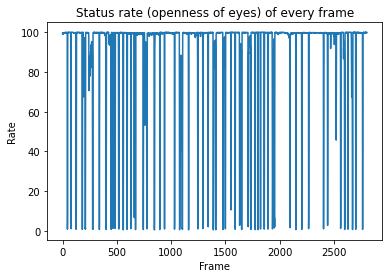

In [6]:
plt.title("Status rate (openness of eyes) of every frame")
plt.xlabel('Frame')
plt.ylabel('Rate')
plt.plot(frames, status_rates)
plt.show()

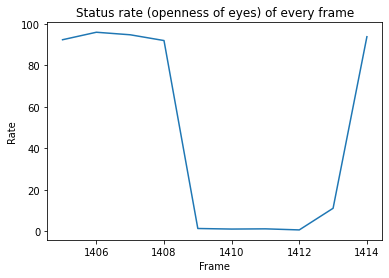

In [13]:
# look at the graph more in depth

frame_start = 1405
frame_end = 1415

plt.title("Status rate (openness of eyes) of every frame")
plt.xlabel('Frame')
plt.ylabel('Rate')
plt.plot(frames[frame_start:frame_end], status_rates[frame_start:frame_end])
plt.show()

In [30]:
# Finds eye-blinks given a sequence of values and a treshhold.
def find_blinks(values, treshhold):
    blink = False
    blinks = []
    blink_count = 0
    for i, val in enumerate(values):
        if val < treshhold:
            if blink == False:
                blink_count +=1
                start = i
            blink = True
        else:
            if blink == True:
                end = i - 1
                #calculate duration of blink, and include in tuple
                duration = end - start + 1
                blinks.append((start, end, duration))
                #print("Blinking period: " + str(start) + " - " + str(end))
            blink = False
    return blinks, blink_count

treshhold = 15
blinks, count = find_blinks(status_rates, treshhold)
print(blinks)
print(np.array(blinks)[:,2])
print(len(blinks))

[(44, 46, 3), (77, 78, 2), (125, 126, 2), (182, 183, 2), (209, 211, 3), (277, 279, 3), (338, 340, 3), (401, 402, 2), (447, 449, 3), (464, 465, 2), (483, 485, 3), (517, 519, 3), (558, 560, 3), (593, 595, 3), (629, 630, 2), (661, 661, 1), (672, 673, 2), (744, 744, 1), (776, 779, 4), (845, 848, 4), (896, 898, 3), (938, 940, 3), (1031, 1033, 3), (1077, 1081, 5), (1102, 1105, 4), (1160, 1162, 3), (1245, 1246, 2), (1292, 1293, 2), (1341, 1341, 1), (1387, 1390, 4), (1409, 1413, 5), (1478, 1480, 3), (1499, 1501, 3), (1551, 1551, 1), (1590, 1591, 2), (1630, 1633, 4), (1648, 1651, 4), (1710, 1710, 1), (1733, 1735, 3), (1774, 1775, 2), (1801, 1802, 2), (1823, 1824, 2), (1858, 1859, 2), (1892, 1893, 2), (1933, 1936, 4), (1951, 1954, 4), (2095, 2095, 1), (2149, 2151, 3), (2203, 2205, 3), (2267, 2268, 2), (2404, 2405, 2), (2442, 2442, 1), (2562, 2563, 2), (2598, 2601, 4), (2629, 2630, 2), (2670, 2673, 4), (2701, 2701, 1), (2764, 2765, 2)]
[3 2 2 2 3 3 3 2 3 2 3 3 3 3 2 1 2 1 4 4 3 3 3 5 4 3 2 2 1 4 

new_segment 460
new_segment 920
new_segment 1380
new_segment 1840
new_segment 2300


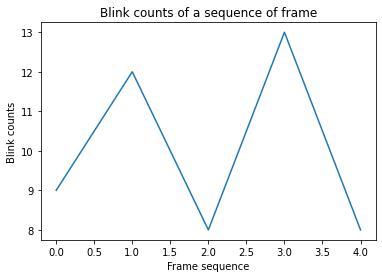

[9, 12, 8, 13, 8]


In [36]:
blink_starts = list(np.array(blinks)[:,0])

def blinks_segment(blink_starts, video_len, segment_len):
    # the amount of frames at the end that are not taken into account
    rest = video_len % segment_len
    num_frames = video_len - rest
    blink_counts = []
    blink_count = 0
    
    # a blink is counted to a segment,when the blink starts in that segment
    for frame in range(num_frames):
        if frame % segment_len == 0 and frame != 0:
            print('new_segment', frame)
            blink_counts.append(blink_count)
            blink_count = 0 
        if frame in blink_starts:
            blink_count += 1
            
    return(blink_counts)
        
    
blink_counts = blinks_segment(blink_starts, 2805, 460)
plt.title("Blink counts of a sequence of frame")
plt.xlabel('Frame sequence')
plt.ylabel('Blink counts')
plt.plot(range(len(blink_counts)), blink_counts)
plt.show()
print(blink_counts)